In [ ]:
import torchvision
from torchvision import transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten().float())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

input_size = dataset.data.flatten(1).shape[1]
hidden_layer_factor = 1
output_size = 10
device = "cpu"

input_scale_factor = 1.0

stationary = True

if stationary:
    hidden_layer = (
        torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
    )  # logistic function this

    output_layer_weights = torch.zeros(output_size, input_size * hidden_layer_factor)
    inhibition_matrix = torch.eye(input_size * hidden_layer_factor, device=device) / (
        input_size * hidden_layer_factor
    )
else:
    print("Not implemented")

In [ ]:
shuffled_indices = torch.randperm(len(dataset))
dataset.data = dataset.data[shuffled_indices]
dataset.targets = dataset.targets[shuffled_indices]

In [ ]:
def run_experiment(
    input_scale_factor, num_training_iterations=2000, stationary=True, epsilon=None
):
    count = 0

    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    accuracy_over_num_images = []
    accuracy_seen_over_num_images = []
    accuracy_per_image = np.zeros(10)
    graphing_interval = 100

    input_size = dataset.data.flatten(1).shape[1]
    hidden_layer_factor = 1
    output_size = 10
    device = "cpu"

    if stationary:
        hidden_layer = (
            torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
        )  # logistic function this

        output_layer_weights = torch.zeros(
            output_size, input_size * hidden_layer_factor
        )
        inhibition_matrix = torch.eye(
            input_size * hidden_layer_factor, device=device
        ) / (input_size * hidden_layer_factor)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            inhibition_matrix = inhibition_matrix - inhibition_matrix @ torch.outer(
                input, b_k.T
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            return inhibition_matrix, weights + weight_update

    else:
        hidden_layer = (
            torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
        )  # logistic function this

        output_layer_weights = torch.zeros(
            output_size, input_size * hidden_layer_factor
        )
        if epsilon == None:
            epsilon = input_size * hidden_layer_factor
        inhibition_matrix = torch.eye(
            input_size * hidden_layer_factor, device=device
        ) / (epsilon**2)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # ERROR VECTOR EK
            e_k = output - weights @ input

            # NORMALIZATION FACTOR
            E = ((e_k.T @ e_k) / input_size * hidden_layer_factor) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # if E != torch.abs(E):
            #     print("abs did something")
            # E = torch.abs(E)

            # GAMMA CALCULATION
            gamma = 1 / (1 + ((1 - torch.exp(-E)) / epsilon))

            inhibition_matrix = gamma * (
                inhibition_matrix
                - inhibition_matrix @ torch.outer(input, b_k.T)
                + ((1 - torch.exp(-E)) / epsilon)
                * torch.eye(input_size * hidden_layer_factor, device=device)
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            # print("Weight upadte", weight_update)
            return inhibition_matrix, weights + weight_update

    for d in dataset:
        count += 1
        input, target = d
        input = input.to(device)
        one_hot_target = (
            torch.nn.functional.one_hot(torch.tensor(target), output_size)
            .float()
            .to(device)
        )
        hidden_layer_output = hidden_layer @ input
        # logistic function for sigmoid activation
        hidden_layer_output = input_scale_factor * torch.sigmoid(hidden_layer_output)
        inhibition_matrix, output_layer_weights = update_output_layer(
            hidden_layer_output, one_hot_target, inhibition_matrix, output_layer_weights
        )

        # test accuracy on whole daataset
        if count % graphing_interval == 0:
            hidden_layer_output = (
                hidden_layer @ dataset.data.flatten(1).float().to(device).T
            )
            hidden_layer_output = input_scale_factor * torch.sigmoid(
                hidden_layer_output
            )
            output = output_layer_weights @ hidden_layer_output
            output = torch.argmax(output, dim=0)
            correct = (output == dataset.targets).sum().item()
            accuracy = correct / len(dataset)
            correct_on_seen = (output[:count] == dataset.targets[:count]).sum().item()
            accuracy_on_seen = correct_on_seen / count
            accuracy_over_num_images.append(accuracy)
            accuracy_seen_over_num_images.append(accuracy_on_seen)
            for i in range(output_size):
                targets = dataset.targets == i
                # print(targets)
                correct = (output[targets] == i).sum().item()
                accuracy_per_image[i] = correct / len(dataset.data[targets])

        if count > num_training_iterations:
            return (
                accuracy_over_num_images,
                accuracy_seen_over_num_images,
                accuracy_per_image,
            )

In [ ]:
candidate_factors = [
    0.01,
    0.1,
    1.0,
    10.0,
    100.0,
    1000.0,
]
# candidate_factors.sort()
num_training_iterations = 1000

accuracies_per_scale_factor = {}
for input_scale_factor in candidate_factors:
    accuracy_over_num_images, accuracy_seen_over_num_images, accuracy_per_image = (
        run_experiment(
            input_scale_factor, num_training_iterations=num_training_iterations
        )
    )

    accuracies_per_scale_factor[input_scale_factor] = (
        accuracy_over_num_images,
        accuracy_seen_over_num_images,
        accuracy_per_image,
    )

plt.figure()
for input_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(
        np.linspace(0, len(accuracy_over_num_images), len(accuracy_over_num_images)),
        accuracy_over_num_images,
        label=f"Input Scale Factor: {input_scale_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Accuracy")
plt.title("Accuracy on all of MNIST")
plt.legend()
plt.show()

plt.figure()
for input_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(
        np.linspace(
            0, len(accuracy_seen_over_num_images), len(accuracy_seen_over_num_images)
        ),
        accuracy_seen_over_num_images,
        label=f"Input Scale Factor: {input_scale_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Accuracy")
plt.title("Accuracy on seen images (training set)")
plt.legend()
plt.show()

plt.figure()
for input_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(accuracy_per_image, label=f"Input Scale Factor: {input_scale_factor}")
plt.xlabel("Number")
plt.ylabel("Accuracy Per Number")
plt.title("Accuracy per number")
plt.legend()
plt.show()

# final mnist accuracies vs scale_factors
plt.figure()
final_accuracy_over_num_images = []
final_accuracy_seen_over_num_images = []

for input_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    final_accuracy_over_num_images.append(accuracy_over_num_images[-1])
    final_accuracy_seen_over_num_images.append(accuracy_seen_over_num_images[-1])

plt.plot(candidate_factors, final_accuracy_over_num_images, label="All MNIST")
plt.plot(candidate_factors, final_accuracy_seen_over_num_images, label="Seen MNIST")
plt.xscale("log")
plt.xlabel("Input Scale Factor")
plt.ylabel("Accuracy")
plt.title("Final Accuracy vs Input Scale Factor")
plt.legend()
plt.show()

In [ ]:
def run_experiment(
    output_scale_factor, num_training_iterations=2000, stationary=True, epsilon=None
):
    count = 0

    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    accuracy_over_num_images = []
    accuracy_seen_over_num_images = []
    accuracy_per_image = np.zeros(10)
    graphing_interval = 100

    input_size = dataset.data.flatten(1).shape[1]
    hidden_layer_factor = 1
    output_size = 10
    device = "cpu"

    if stationary:
        hidden_layer = (
            torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
        )  # logistic function this

        output_layer_weights = torch.zeros(
            output_size, input_size * hidden_layer_factor
        )
        inhibition_matrix = torch.eye(
            input_size * hidden_layer_factor, device=device
        ) / (input_size * hidden_layer_factor)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            inhibition_matrix = inhibition_matrix - inhibition_matrix @ torch.outer(
                input, b_k.T
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            return inhibition_matrix, weights + weight_update

    else:
        hidden_layer = (
            torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
        )  # logistic function this

        output_layer_weights = torch.zeros(
            output_size, input_size * hidden_layer_factor
        )
        if epsilon == None:
            epsilon = input_size * hidden_layer_factor
        inhibition_matrix = torch.eye(
            input_size * hidden_layer_factor, device=device
        ) / (epsilon**2)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # ERROR VECTOR EK
            e_k = output - weights @ input

            # NORMALIZATION FACTOR
            E = ((e_k.T @ e_k) / input_size * hidden_layer_factor) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # E = torch.abs(E)

            # GAMMA CALCULATION
            gamma = 1 / (1 + ((1 - torch.exp(-E)) / epsilon))

            inhibition_matrix = gamma * (
                inhibition_matrix
                - inhibition_matrix @ torch.outer(input, b_k.T)
                + ((1 - torch.exp(-E)) / epsilon)
                * torch.eye(input_size * hidden_layer_factor, device=device)
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            # print("Weight upadte", weight_update)
            return inhibition_matrix, weights + weight_update

    for d in dataset:
        count += 1
        input, target = d
        input = input.to(device)
        one_hot_target = output_scale_factor * (
            torch.nn.functional.one_hot(torch.tensor(target), output_size)
            .float()
            .to(device)
        )
        # print("One Hot Target", one_hot_target, target)
        # print(input.shape)
        hidden_layer_output = hidden_layer @ input
        # logistic function for sigmoid activation
        hidden_layer_output = torch.sigmoid(hidden_layer_output)
        inhibition_matrix, output_layer_weights = update_output_layer(
            hidden_layer_output, one_hot_target, inhibition_matrix, output_layer_weights
        )

        # print("Weights", output_layer_weights)
        # print("Max weight", torch.max(output_layer_weights))
        # print("Min weight", torch.min(output_layer_weights))

        # inhibition_matrix, output_layer_weights = update_output_layer_non_stationary(
        #     hidden_layer_output, one_hot_target, inhibition_matrix, output_layer_weights
        # )

        # test accuracy on whole daataset
        if count % graphing_interval == 0:
            # print("Images seen", count)
            hidden_layer_output = (
                hidden_layer @ dataset.data.flatten(1).float().to(device).T
            )
            hidden_layer_output = torch.sigmoid(hidden_layer_output)
            output = output_layer_weights @ hidden_layer_output
            # print(output)
            # print(
            #     "max of the output (should be less than 1 if working properly)",
            #     torch.max(output),
            # )
            output = torch.argmax(output, dim=0)
            correct = (output == dataset.targets).sum().item()
            accuracy = correct / len(dataset)
            correct_on_seen = (output[:count] == dataset.targets[:count]).sum().item()
            accuracy_on_seen = correct_on_seen / count
            accuracy_over_num_images.append(accuracy)
            accuracy_seen_over_num_images.append(accuracy_on_seen)
            for i in range(output_size):
                targets = dataset.targets == i
                # print(targets)
                correct = (output[targets] == i).sum().item()
                accuracy_per_image[i] = correct / len(dataset.data[targets])

        if count > num_training_iterations:
            # print(f"Accuracy on whole dataset: {accuracy}")
            # print(f"Accuracy on seen images: {accuracy_on_seen}")
            # print(f"Accuracy per image: {accuracy_per_image}")
            # plt.plot(
            #     np.linspace(0, count, len(accuracy_over_num_images)),
            #     accuracy_over_num_images,
            # )
            # plt.xlabel("Number of images trained")
            # plt.ylabel("Accuracy")
            # plt.title(f"Accuracy on all of MNIST {output_scale_factor}")
            # plt.show()
            # plt.plot(
            #     np.linspace(0, count, len(accuracy_seen_over_num_images)),
            #     accuracy_seen_over_num_images,
            # )
            # plt.xlabel("Number of images trained")
            # plt.ylabel("Accuracy")
            # plt.title(f"Accuracy on seen images (training set) {output_scale_factor}")
            # plt.show()
            # plt.plot(accuracy_per_image)
            # plt.xlabel("Number")
            # plt.ylabel("Accuracy Per Number")
            # plt.title(f"Accuracy per number {output_scale_factor}")
            # plt.show()

            return (
                accuracy_over_num_images,
                accuracy_seen_over_num_images,
                accuracy_per_image,
            )

In [ ]:
candidate_factors = [
    0.001,
    0.01,
    0.1,
    1.0,
    10.0,
    100.0,
    1000.0,
]
# candidate_factors.sort()
num_training_iterations = 1000

accuracies_per_scale_factor = {}
for output_scale_factor in candidate_factors:
    accuracy_over_num_images, accuracy_seen_over_num_images, accuracy_per_image = (
        run_experiment(
            output_scale_factor, num_training_iterations=num_training_iterations
        )
    )

    accuracies_per_scale_factor[output_scale_factor] = (
        accuracy_over_num_images,
        accuracy_seen_over_num_images,
        accuracy_per_image,
    )

plt.figure()
for output_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(
        np.linspace(0, len(accuracy_over_num_images), len(accuracy_over_num_images)),
        accuracy_over_num_images,
        label=f"Output Scale Factor: {output_scale_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Accuracy")
plt.title("Accuracy on all of MNIST")
plt.legend()
plt.show()

plt.figure()
for output_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(
        np.linspace(
            0, len(accuracy_seen_over_num_images), len(accuracy_seen_over_num_images)
        ),
        accuracy_seen_over_num_images,
        label=f"Output Scale Factor: {output_scale_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Accuracy")
plt.title("Accuracy on seen images (training set)")
plt.legend()
plt.show()

plt.figure()
for output_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(accuracy_per_image, label=f"Output Scale Factor: {output_scale_factor}")
plt.xlabel("Number")
plt.ylabel("Accuracy Per Number")
plt.title("Accuracy per number")
plt.legend()
plt.show()

# final mnist accuracies vs scale_factors
plt.figure()
final_accuracy_over_num_images = []
final_accuracy_seen_over_num_images = []

for output_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    final_accuracy_over_num_images.append(accuracy_over_num_images[-1])
    final_accuracy_seen_over_num_images.append(accuracy_seen_over_num_images[-1])

plt.plot(candidate_factors, final_accuracy_over_num_images, label="All MNIST")
plt.plot(candidate_factors, final_accuracy_seen_over_num_images, label="Seen MNIST")
plt.xscale("log")
plt.xlabel("Output Scale Factor")
plt.ylabel("Accuracy")
plt.title("Final Accuracy vs Output Scale Factor")
plt.legend()
plt.show()

with nonstationary method

In [ ]:
def run_experiment(
    input_scale_factor, num_training_iterations=2000, stationary=True, epsilon=None
):
    count = 0

    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    accuracy_over_num_images = []
    accuracy_seen_over_num_images = []
    accuracy_per_image = np.zeros(10)
    graphing_interval = 100

    input_size = dataset.data.flatten(1).shape[1]
    hidden_layer_factor = 1
    output_size = 10
    device = "cpu"

    if stationary:
        hidden_layer = (
            torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
        )  # logistic function this

        output_layer_weights = torch.zeros(
            output_size, input_size * hidden_layer_factor
        )
        inhibition_matrix = torch.eye(
            input_size * hidden_layer_factor, device=device
        ) / (input_size * hidden_layer_factor)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            inhibition_matrix = inhibition_matrix - inhibition_matrix @ torch.outer(
                input, b_k.T
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            return inhibition_matrix, weights + weight_update

    else:
        hidden_layer = (
            torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
        )  # logistic function this

        output_layer_weights = torch.zeros(
            output_size, input_size * hidden_layer_factor
        )
        if epsilon == None:
            epsilon = input_size * hidden_layer_factor
        inhibition_matrix = torch.eye(
            input_size * hidden_layer_factor, device=device
        ) / (epsilon**2)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # ERROR VECTOR EK
            e_k = output - weights @ input

            # NORMALIZATION FACTOR
            E = ((e_k.T @ e_k) / input_size * hidden_layer_factor) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # E = torch.abs(E)

            # GAMMA CALCULATION
            gamma = 1 / (1 + ((1 - torch.exp(-E)) / epsilon))

            inhibition_matrix = gamma * (
                inhibition_matrix
                - inhibition_matrix @ torch.outer(input, b_k.T)
                + ((1 - torch.exp(-E)) / epsilon)
                * torch.eye(input_size * hidden_layer_factor, device=device)
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            # print("Weight upadte", weight_update)
            return inhibition_matrix, weights + weight_update

    for d in dataset:
        count += 1
        input, target = d
        input = input.to(device)
        one_hot_target = (
            torch.nn.functional.one_hot(torch.tensor(target), output_size)
            .float()
            .to(device)
        )
        hidden_layer_output = hidden_layer @ input
        # logistic function for sigmoid activation
        hidden_layer_output = input_scale_factor * torch.sigmoid(hidden_layer_output)
        inhibition_matrix, output_layer_weights = update_output_layer(
            hidden_layer_output, one_hot_target, inhibition_matrix, output_layer_weights
        )

        # test accuracy on whole daataset
        if count % graphing_interval == 0:
            hidden_layer_output = (
                hidden_layer @ dataset.data.flatten(1).float().to(device).T
            )
            hidden_layer_output = input_scale_factor * torch.sigmoid(
                hidden_layer_output
            )
            output = output_layer_weights @ hidden_layer_output
            output = torch.argmax(output, dim=0)
            correct = (output == dataset.targets).sum().item()
            accuracy = correct / len(dataset)
            correct_on_seen = (output[:count] == dataset.targets[:count]).sum().item()
            accuracy_on_seen = correct_on_seen / count
            accuracy_over_num_images.append(accuracy)
            accuracy_seen_over_num_images.append(accuracy_on_seen)
            for i in range(output_size):
                targets = dataset.targets == i
                # print(targets)
                correct = (output[targets] == i).sum().item()
                accuracy_per_image[i] = correct / len(dataset.data[targets])

        if count > num_training_iterations:
            return (
                accuracy_over_num_images,
                accuracy_seen_over_num_images,
                accuracy_per_image,
            )

In [ ]:
candidate_factors = [
    0.01,
    0.1,
    1.0,
    10.0,
    100.0,
    1000.0,
]
# candidate_factors.sort()
num_training_iterations = 1000

accuracies_per_scale_factor = {}
for input_scale_factor in candidate_factors:
    accuracy_over_num_images, accuracy_seen_over_num_images, accuracy_per_image = (
        run_experiment(
            input_scale_factor,
            num_training_iterations=num_training_iterations,
            stationary=False,
        )
    )

    accuracies_per_scale_factor[input_scale_factor] = (
        accuracy_over_num_images,
        accuracy_seen_over_num_images,
        accuracy_per_image,
    )

plt.figure()
for input_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(
        np.linspace(0, len(accuracy_over_num_images), len(accuracy_over_num_images)),
        accuracy_over_num_images,
        label=f"Input Scale Factor: {input_scale_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Accuracy")
plt.title("Accuracy on all of MNIST")
plt.legend()
plt.show()

plt.figure()
for input_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(
        np.linspace(
            0, len(accuracy_seen_over_num_images), len(accuracy_seen_over_num_images)
        ),
        accuracy_seen_over_num_images,
        label=f"Input Scale Factor: {input_scale_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Accuracy")
plt.title("Accuracy on seen images (training set)")
plt.legend()
plt.show()

plt.figure()
for input_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(accuracy_per_image, label=f"Input Scale Factor: {input_scale_factor}")
plt.xlabel("Number")
plt.ylabel("Accuracy Per Number")
plt.title("Accuracy per number")
plt.legend()
plt.show()

# final mnist accuracies vs scale_factors
plt.figure()
final_accuracy_over_num_images = []
final_accuracy_seen_over_num_images = []

for input_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    final_accuracy_over_num_images.append(accuracy_over_num_images[-1])
    final_accuracy_seen_over_num_images.append(accuracy_seen_over_num_images[-1])

plt.plot(candidate_factors, final_accuracy_over_num_images, label="All MNIST")
plt.plot(candidate_factors, final_accuracy_seen_over_num_images, label="Seen MNIST")
plt.xscale("log")
plt.xlabel("Input Scale Factor")
plt.ylabel("Accuracy")
plt.title("Final Accuracy vs Input Scale Factor")
plt.legend()
plt.show()

In [ ]:
def run_experiment(
    output_scale_factor, num_training_iterations=2000, stationary=True, epsilon=None
):
    count = 0

    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    accuracy_over_num_images = []
    accuracy_seen_over_num_images = []
    accuracy_per_image = np.zeros(10)
    graphing_interval = 100

    input_size = dataset.data.flatten(1).shape[1]
    hidden_layer_factor = 1
    output_size = 10
    device = "cpu"

    if stationary:
        hidden_layer = (
            torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
        )  # logistic function this

        output_layer_weights = torch.zeros(
            output_size, input_size * hidden_layer_factor
        )
        inhibition_matrix = torch.eye(
            input_size * hidden_layer_factor, device=device
        ) / (input_size * hidden_layer_factor)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            inhibition_matrix = inhibition_matrix - inhibition_matrix @ torch.outer(
                input, b_k.T
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            return inhibition_matrix, weights + weight_update

    else:
        hidden_layer = (
            torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
        )  # logistic function this

        output_layer_weights = torch.zeros(
            output_size, input_size * hidden_layer_factor
        )
        if epsilon == None:
            epsilon = input_size * hidden_layer_factor
        inhibition_matrix = torch.eye(
            input_size * hidden_layer_factor, device=device
        ) / (epsilon**2)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # ERROR VECTOR EK
            e_k = output - weights @ input

            # NORMALIZATION FACTOR
            E = ((e_k.T @ e_k) / input_size * hidden_layer_factor) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # E = torch.abs(E)

            # GAMMA CALCULATION
            gamma = 1 / (1 + ((1 - torch.exp(-E)) / epsilon))

            inhibition_matrix = gamma * (
                inhibition_matrix
                - inhibition_matrix @ torch.outer(input, b_k.T)
                + ((1 - torch.exp(-E)) / epsilon)
                * torch.eye(input_size * hidden_layer_factor, device=device)
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            # print("Weight upadte", weight_update)
            return inhibition_matrix, weights + weight_update

    for d in dataset:
        count += 1
        input, target = d
        input = input.to(device)
        one_hot_target = output_scale_factor * (
            torch.nn.functional.one_hot(torch.tensor(target), output_size)
            .float()
            .to(device)
        )
        # print("One Hot Target", one_hot_target, target)
        # print(input.shape)
        hidden_layer_output = hidden_layer @ input
        # logistic function for sigmoid activation
        hidden_layer_output = torch.sigmoid(hidden_layer_output)
        inhibition_matrix, output_layer_weights = update_output_layer(
            hidden_layer_output, one_hot_target, inhibition_matrix, output_layer_weights
        )

        # print("Weights", output_layer_weights)
        # print("Max weight", torch.max(output_layer_weights))
        # print("Min weight", torch.min(output_layer_weights))

        # inhibition_matrix, output_layer_weights = update_output_layer_non_stationary(
        #     hidden_layer_output, one_hot_target, inhibition_matrix, output_layer_weights
        # )

        # test accuracy on whole daataset
        if count % graphing_interval == 0:
            # print("Images seen", count)
            hidden_layer_output = (
                hidden_layer @ dataset.data.flatten(1).float().to(device).T
            )
            hidden_layer_output = torch.sigmoid(hidden_layer_output)
            output = output_layer_weights @ hidden_layer_output
            # print(output)
            # print(
            #     "max of the output (should be less than 1 if working properly)",
            #     torch.max(output),
            # )
            output = torch.argmax(output, dim=0)
            correct = (output == dataset.targets).sum().item()
            accuracy = correct / len(dataset)
            correct_on_seen = (output[:count] == dataset.targets[:count]).sum().item()
            accuracy_on_seen = correct_on_seen / count
            accuracy_over_num_images.append(accuracy)
            accuracy_seen_over_num_images.append(accuracy_on_seen)
            for i in range(output_size):
                targets = dataset.targets == i
                # print(targets)
                correct = (output[targets] == i).sum().item()
                accuracy_per_image[i] = correct / len(dataset.data[targets])

        if count > num_training_iterations:
            # print(f"Accuracy on whole dataset: {accuracy}")
            # print(f"Accuracy on seen images: {accuracy_on_seen}")
            # print(f"Accuracy per image: {accuracy_per_image}")
            # plt.plot(
            #     np.linspace(0, count, len(accuracy_over_num_images)),
            #     accuracy_over_num_images,
            # )
            # plt.xlabel("Number of images trained")
            # plt.ylabel("Accuracy")
            # plt.title(f"Accuracy on all of MNIST {output_scale_factor}")
            # plt.show()
            # plt.plot(
            #     np.linspace(0, count, len(accuracy_seen_over_num_images)),
            #     accuracy_seen_over_num_images,
            # )
            # plt.xlabel("Number of images trained")
            # plt.ylabel("Accuracy")
            # plt.title(f"Accuracy on seen images (training set) {output_scale_factor}")
            # plt.show()
            # plt.plot(accuracy_per_image)
            # plt.xlabel("Number")
            # plt.ylabel("Accuracy Per Number")
            # plt.title(f"Accuracy per number {output_scale_factor}")
            # plt.show()

            return (
                accuracy_over_num_images,
                accuracy_seen_over_num_images,
                accuracy_per_image,
            )

In [ ]:
candidate_factors = [
    0.001,
    0.01,
    0.1,
    1.0,
    10.0,
    100.0,
    1000.0,
]
# candidate_factors.sort()
num_training_iterations = 1000

accuracies_per_scale_factor = {}
for output_scale_factor in candidate_factors:
    accuracy_over_num_images, accuracy_seen_over_num_images, accuracy_per_image = (
        run_experiment(
            output_scale_factor,
            num_training_iterations=num_training_iterations,
            stationary=False,
        )
    )

    accuracies_per_scale_factor[output_scale_factor] = (
        accuracy_over_num_images,
        accuracy_seen_over_num_images,
        accuracy_per_image,
    )

plt.figure()
for output_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(
        np.linspace(0, len(accuracy_over_num_images), len(accuracy_over_num_images)),
        accuracy_over_num_images,
        label=f"Output Scale Factor: {output_scale_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Accuracy")
plt.title("Accuracy on all of MNIST")
plt.legend()
plt.show()

plt.figure()
for output_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(
        np.linspace(
            0, len(accuracy_seen_over_num_images), len(accuracy_seen_over_num_images)
        ),
        accuracy_seen_over_num_images,
        label=f"Output Scale Factor: {output_scale_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Accuracy")
plt.title("Accuracy on seen images (training set)")
plt.legend()
plt.show()

plt.figure()
for output_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    plt.plot(accuracy_per_image, label=f"Output Scale Factor: {output_scale_factor}")
plt.xlabel("Number")
plt.ylabel("Accuracy Per Number")
plt.title("Accuracy per number")
plt.legend()
plt.show()

# final mnist accuracies vs scale_factors
plt.figure()
final_accuracy_over_num_images = []
final_accuracy_seen_over_num_images = []

for output_scale_factor, (
    accuracy_over_num_images,
    accuracy_seen_over_num_images,
    accuracy_per_image,
) in accuracies_per_scale_factor.items():
    final_accuracy_over_num_images.append(accuracy_over_num_images[-1])
    final_accuracy_seen_over_num_images.append(accuracy_seen_over_num_images[-1])

plt.plot(candidate_factors, final_accuracy_over_num_images, label="All MNIST")
plt.plot(candidate_factors, final_accuracy_seen_over_num_images, label="Seen MNIST")
plt.xscale("log")
plt.xlabel("Output Scale Factor")
plt.ylabel("Accuracy")
plt.title("Final Accuracy vs Output Scale Factor")
plt.legend()
plt.show()

### ON MORE VECTORHASHY THINGS ###

Sensory to hippocampal testing

In [1]:
import math
from matrix_initializers import SparseMatrixByScalingInitializer
from scipy.stats import norm
import torchvision
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

device = "cpu"
lambdas = [3, 4, 5]
shapes = [(i, i) for i in lambdas]

percent_nonzero_relu = 0.5  #
W_gh_var = 1
sparse_initialization = 0.1

ls = [torch.prod(torch.tensor(shape)).item() for shape in shapes]
N_patts = np.prod([l for l in ls]).item()
N_g = sum([l for l in ls])
N_h = 250
relu_theta = 0.5
W_hg_std = math.sqrt(W_gh_var)
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))

W_hg = SparseMatrixByScalingInitializer(scale=W_hg_std, mean=W_hg_mean, device=device)(
    (N_h, N_g)
)

# get G book
gbook = torch.zeros((N_patts, N_g), device=device)
i = 0
for l in ls:
    gbook[:, i : i + l] = torch.tile(
        torch.eye(l, device=device),
        (N_patts // l, 1),
    )
    i += l
print(gbook.shape)

# get H book
hbook = torch.relu(gbook @ W_hg.T - relu_theta)
print(hbook.shape)

# get S book
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten().float())]
)
dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)
dataset.data = dataset.data[:N_patts].flatten(1).float()
dataset.targets = dataset.targets[:N_patts]
print(dataset.data.shape)
print(dataset.targets.shape)

# just num_imgs from each
# dataset.data = dataset.data[:num_imgs]
# dataset.targets = dataset.targets[:num_imgs]

# hbook = hbook[:num_imgs]
# gbook = gbook[:num_imgs]

torch.Size([3600, 50])
torch.Size([3600, 250])
torch.Size([3600, 784])
torch.Size([3600])


In [2]:
num_imgs = 1000

# Test pseudo-inverse from sbook to hbook
input_size = dataset.data.flatten(1).shape[1]
device = "cpu"


def run_experiment(
    hidden_layer_factor,
    raw_image_scaling_factor=1.0,
    raw_image_shift=0.0,
    hidden_layer_scaling_factor=1.0,
    stationary=True,
    epsilon=None,
):
    data = raw_image_scaling_factor * (dataset.data - raw_image_shift)
    print(torch.max(data), torch.min(data))
    if stationary:
        if hidden_layer_factor != 0:
            hidden_layer = (
                torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
            )  # logistic function this

            output_layer_weights = torch.zeros(
                hbook.shape[1], input_size * hidden_layer_factor
            )
            inhibition_matrix = torch.eye(
                input_size * hidden_layer_factor, device=device
            ) / (input_size * hidden_layer_factor)
        else:
            output_layer_weights = torch.zeros(hbook.shape[1], input_size)
            inhibition_matrix = torch.eye(input_size, device=device) / (input_size)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            inhibition_matrix = inhibition_matrix - inhibition_matrix @ torch.outer(
                input, b_k.T
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            return (
                inhibition_matrix,
                weights + weight_update,
                torch.max(weight_update),
                torch.mean(weight_update),
            )

    else:
        if hidden_layer_factor != 0:
            hidden_layer = (
                torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
            )  # logistic function this
            output_layer_weights = torch.zeros(
                hbook.shape[1], input_size * hidden_layer_factor
            )
            if epsilon == None:
                epsilon = input_size * hidden_layer_factor
            inhibition_matrix = torch.eye(
                input_size * hidden_layer_factor, device=device
            ) / (epsilon**2)
        else:
            if epsilon == None:
                epsilon = input_size
            output_layer_weights = torch.zeros(hbook.shape[1], input_size)
            inhibition_matrix = torch.eye(input_size, device=device) / (epsilon**2)

        def update_output_layer(input, output, inhibition_matrix, weights):
            b_k = (inhibition_matrix @ input) / (
                1 + input.T @ inhibition_matrix @ input
            )
            # ERROR VECTOR EK
            e_k = output - weights @ input

            # NORMALIZATION FACTOR
            E = ((e_k.T @ e_k) / inhibition_matrix.shape[0]) / (
                1 + input.T @ inhibition_matrix @ input
            )
            if E != torch.abs(E):
                print("abs did something")
            E = torch.abs(E)

            # GAMMA CALCULATION
            gamma = 1 / (1 + ((1 - torch.exp(-E)) / epsilon))

            inhibition_matrix = gamma * (
                inhibition_matrix
                - inhibition_matrix @ torch.outer(input, b_k.T)
                + ((1 - torch.exp(-E)) / epsilon)
                * torch.eye(inhibition_matrix.shape[0], device=device)
            )
            weight_update = torch.outer((output - weights @ input), b_k.T)
            # print("Weight upadte", weight_update)
            return (
                inhibition_matrix,
                weights + weight_update,
                torch.max(weight_update),
                torch.mean(weight_update),
            )

    cosine_similarities = []
    mses = []
    max_weight_changes = []
    mean_weight_changes = []
    for i in range(num_imgs):
        input = data[i]
        input = input.to(device)

        if hidden_layer_factor != 0:
            hidden_layer_output = hidden_layer @ input
            hidden_layer_output = (
                torch.sigmoid(hidden_layer_output) * hidden_layer_scaling_factor
            )
        else:
            hidden_layer_output = input
        (
            inhibition_matrix,
            output_layer_weights,
            max_weight_change,
            mean_weight_change,
        ) = update_output_layer(
            hidden_layer_output, hbook[i], inhibition_matrix, output_layer_weights
        )

        # compare s to h with hbook using MSE and cosine similarity
        if hidden_layer_factor != 0:
            hidden_layer_output = hidden_layer @ data[:i].T
            hidden_layer_output = (
                torch.sigmoid(hidden_layer_output) * hidden_layer_scaling_factor
            )
        else:
            hidden_layer_output = data[:i].T
        output = (output_layer_weights @ hidden_layer_output).T

        mse = torch.nn.functional.mse_loss(output, hbook[:i], reduction="mean")
        cosine = torch.cosine_similarity(output, hbook[:i], dim=1).mean()

        mses.append(mse)
        cosine_similarities.append(cosine)
        max_weight_changes.append(max_weight_change)
        mean_weight_changes.append(mean_weight_change)

        # print(hbook.shape)
        # print(output.shape)
        # print("MSE", mse)
        # print("Cosine Similarity", cosine)
    return mses, cosine_similarities, max_weight_changes, mean_weight_changes

In [ ]:
hidden_layer_factors = [0, 1, 2]
# hidden_layer_factors = []


# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for hidden_layer_factor in hidden_layer_factors:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        hidden_layer_factor
    )
    experiment_results[hidden_layer_factor] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for hidden_layer_factor, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Factor: {hidden_layer_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_factor, (_, cosine_similarities, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Factor: {hidden_layer_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for hidden_layer_factor, (_, _, max_weight_changes, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Factor: {hidden_layer_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_factor, (_, _, _, mean_weight_changes) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Factor: {hidden_layer_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
raw_image_scaling_factors = [0.01, 0.1, 1.0, 10.0, 100.0]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for raw_image_scaling_factor in raw_image_scaling_factors:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        0, raw_image_scaling_factor=raw_image_scaling_factor
    )
    experiment_results[raw_image_scaling_factor] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for raw_image_scaling_factor, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 10)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for raw_image_scaling_factor, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for raw_image_scaling_factor, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.05)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for raw_image_scaling_factor, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
raw_image_scaling_factors = [0.01, 1.0, 10.0]
raw_image_shift = [0.0, 255.0 / 2]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for raw_image_scaling_factor in raw_image_scaling_factors:
    for raw_image_shift_factor in raw_image_shift:
        mses, cosine_similarities, max_weight_changes, mean_weight_changes = (
            run_experiment(
                0,
                raw_image_scaling_factor=raw_image_scaling_factor,
                raw_image_shift=raw_image_shift_factor,
            )
        )
        experiment_results[(raw_image_scaling_factor, raw_image_shift_factor)] = (
            mses,
            cosine_similarities,
            max_weight_changes,
            mean_weight_changes,
        )

plt.figure()
for (raw_image_scaling_factor, raw_image_shift), (
    mses,
    _,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Raw Image Scaling: {raw_image_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 10)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for (raw_image_scaling_factor, raw_image_shift), (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Raw Image Scaling: {raw_image_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for (raw_image_scaling_factor, raw_image_shift), (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Raw Image Scaling: {raw_image_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.05)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for (raw_image_scaling_factor, raw_image_shift), (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Raw Image Scaling: {raw_image_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
raw_image_scaling_factors = [0.01, 0.1, 1.0, 10.0, 100.0]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for raw_image_scaling_factor in raw_image_scaling_factors:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        1, raw_image_scaling_factor=raw_image_scaling_factor
    )
    experiment_results[raw_image_scaling_factor] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for raw_image_scaling_factor, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for raw_image_scaling_factor, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for raw_image_scaling_factor, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for raw_image_scaling_factor, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
hidden_layer_scaling_factors = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 100000.0]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for hidden_layer_scaling_factor in hidden_layer_scaling_factors:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        1, hidden_layer_scaling_factor=hidden_layer_scaling_factor
    )
    experiment_results[hidden_layer_scaling_factor] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for hidden_layer_scaling_factor, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Scaling Factor: {hidden_layer_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 300)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_scaling_factor, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Scaling Factor: {hidden_layer_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_scaling_factor, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Scaling Factor: {hidden_layer_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.025)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_scaling_factor, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Scaling Factor: {hidden_layer_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
hidden_layer_scaling_factors = [0.01, 1.0, 10.0]
raw_image_shift = [0.0, 255.0 / 2]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for hidden_layer_scaling_factor in hidden_layer_scaling_factors:
    for raw_image_shift_factor in raw_image_shift:
        mses, cosine_similarities, max_weight_changes, mean_weight_changes = (
            run_experiment(
                0,
                hidden_layer_scaling_factor=hidden_layer_scaling_factor,
                raw_image_shift=raw_image_shift_factor,
            )
        )
        experiment_results[(hidden_layer_scaling_factor, raw_image_shift_factor)] = (
            mses,
            cosine_similarities,
            max_weight_changes,
            mean_weight_changes,
        )

plt.figure()
for (hidden_layer_scaling_factor, raw_image_shift), (
    mses,
    _,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Scaling: {hidden_layer_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 10)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for (hidden_layer_scaling_factor, raw_image_shift), (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Scaling: {hidden_layer_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for (hidden_layer_scaling_factor, raw_image_shift), (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Scaling: {hidden_layer_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.05)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for (hidden_layer_scaling_factor, raw_image_shift), (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Scaling: {hidden_layer_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

Does N_h make a difference? 

In [ ]:
N_hs = [50, 250, 500, 1000, 10000]

experiment_results = {}
for N_h in N_hs:
    W_hg = SparseMatrixByScalingInitializer(
        scale=W_hg_std, mean=W_hg_mean, device=device
    )((N_h, N_g))

    # get H book
    hbook = torch.relu(gbook @ W_hg.T - relu_theta)
    print(hbook.shape)

    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        1, 1, 10
    )
    experiment_results[N_h] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for N_h, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.025)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
N_hs = [50, 250, 500, 1000, 10000]

experiment_results = {}
for N_h in N_hs:
    W_hg = SparseMatrixByScalingInitializer(
        scale=W_hg_std, mean=W_hg_mean, device=device
    )((N_h, N_g))

    # get H book
    hbook = torch.relu(gbook @ W_hg.T - relu_theta)
    print(hbook.shape)

    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        0, 1, 1
    )
    experiment_results[N_h] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for N_h, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.025)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

Nonstationary

In [ ]:
hidden_layer_factors = [0, 1, 2, 5, 10]
# hidden_layer_factors = []


# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for hidden_layer_factor in hidden_layer_factors:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        hidden_layer_factor, stationary=False
    )
    experiment_results[hidden_layer_factor] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for hidden_layer_factor, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Factor: {hidden_layer_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_factor, (_, cosine_similarities, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Factor: {hidden_layer_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for hidden_layer_factor, (_, _, max_weight_changes, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Factor: {hidden_layer_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_factor, (_, _, _, mean_weight_changes) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Factor: {hidden_layer_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

tensor(255.) tensor(0.)


/var/folders/by/wwwbwc016yxfhlbgfph7_xmc0000gn/T/ipykernel_55206/2373860158.py:70: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  1 + input.T @ inhibition_matrix @ input


tensor(255.) tensor(0.)
tensor(255.) tensor(0.)
tensor(255.) tensor(0.)
tensor(255.) tensor(0.)
tensor(255.) tensor(0.)
tensor(255.) tensor(0.)
tensor(255.) tensor(0.)
tensor(255.) tensor(0.)


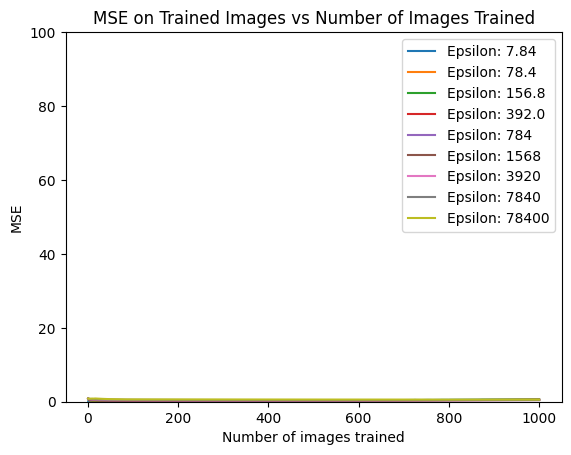

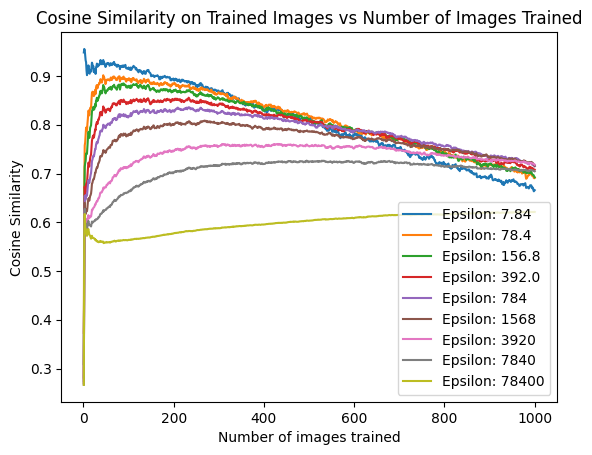

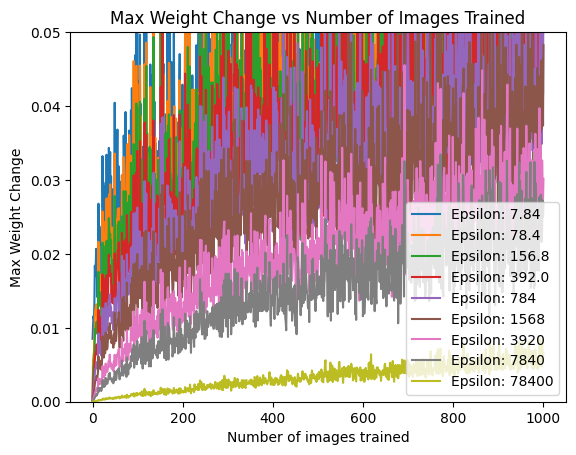

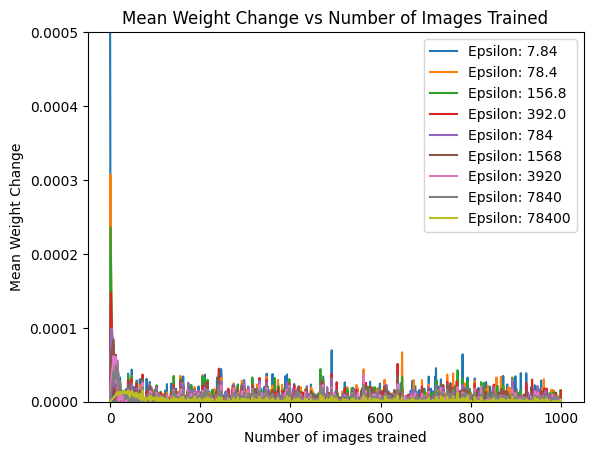

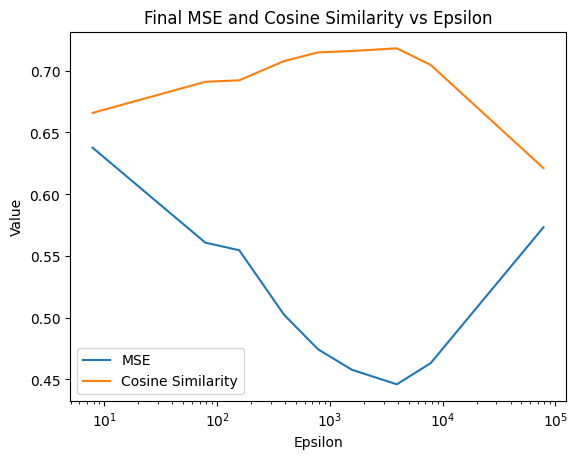

In [3]:
hidden_layer_factor = 1
base_epsilon = 784 * hidden_layer_factor
epsilons = [
    base_epsilon / 100,
    base_epsilon / 10,
    base_epsilon / 5,
    base_epsilon / 2,
    base_epsilon,
    base_epsilon * 2,
    base_epsilon * 5,
    base_epsilon * 10,
    base_epsilon * 100,
]

# plot mses and cosine similarities for each epsilon on seperate graphs
experiment_results = {}
for epsilon in epsilons:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        hidden_layer_factor,
        stationary=False,
        epsilon=epsilon,
    )
    experiment_results[epsilon] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for epsilon, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Epsilon: {epsilon}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 100)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for epsilon, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Epsilon: {epsilon}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for epsilon, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Epsilon: {epsilon}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.05)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for epsilon, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Epsilon: {epsilon}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

# final mnist mse and cosine vs epsilons
plt.figure()
final_mses = []
final_cosine_similarities = []

for epsilon, (mses, cosine_similarities, _, _) in experiment_results.items():
    final_mses.append(mses[-1])
    final_cosine_similarities.append(cosine_similarities[-1])

plt.plot(epsilons, final_mses, label="MSE")
plt.plot(epsilons, final_cosine_similarities, label="Cosine Similarity")
plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("Value")
plt.title("Final MSE and Cosine Similarity vs Epsilon")
plt.legend()
plt.show()

In [ ]:
raw_image_scaling_factors = [0.01, 0.1, 1.0, 10.0, 100.0]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for raw_image_scaling_factor in raw_image_scaling_factors:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        0, raw_image_scaling_factor=raw_image_scaling_factor, stationary=False
    )
    experiment_results[raw_image_scaling_factor] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for raw_image_scaling_factor, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 200)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for raw_image_scaling_factor, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for raw_image_scaling_factor, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.05)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for raw_image_scaling_factor, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
raw_image_scaling_factors = [0.01, 1.0, 10.0]
raw_image_shift = [0.0, 255.0 / 2]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for raw_image_scaling_factor in raw_image_scaling_factors:
    for raw_image_shift_factor in raw_image_shift:
        mses, cosine_similarities, max_weight_changes, mean_weight_changes = (
            run_experiment(
                0,
                raw_image_scaling_factor=raw_image_scaling_factor,
                raw_image_shift=raw_image_shift_factor,
                stationary=False,
            )
        )
        experiment_results[(raw_image_scaling_factor, raw_image_shift_factor)] = (
            mses,
            cosine_similarities,
            max_weight_changes,
            mean_weight_changes,
        )

plt.figure()
for (raw_image_scaling_factor, raw_image_shift), (
    mses,
    _,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Raw Image Scaling: {raw_image_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 10)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for (raw_image_scaling_factor, raw_image_shift), (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Raw Image Scaling: {raw_image_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for (raw_image_scaling_factor, raw_image_shift), (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Raw Image Scaling: {raw_image_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.05)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for (raw_image_scaling_factor, raw_image_shift), (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Raw Image Scaling: {raw_image_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
raw_image_scaling_factors = [0.01, 0.1, 1.0, 10.0, 100.0]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for raw_image_scaling_factor in raw_image_scaling_factors:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        1, raw_image_scaling_factor=raw_image_scaling_factor, stationary=False
    )
    experiment_results[raw_image_scaling_factor] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for raw_image_scaling_factor, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for raw_image_scaling_factor, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for raw_image_scaling_factor, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for raw_image_scaling_factor, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Raw Image Scaling Factor: {raw_image_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
hidden_layer_scaling_factors = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 100000.0]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for hidden_layer_scaling_factor in hidden_layer_scaling_factors:
    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        1, hidden_layer_scaling_factor=hidden_layer_scaling_factor, stationary=False
    )
    experiment_results[hidden_layer_scaling_factor] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for hidden_layer_scaling_factor, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Scaling Factor: {hidden_layer_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 300)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_scaling_factor, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Scaling Factor: {hidden_layer_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_scaling_factor, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Scaling Factor: {hidden_layer_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.025)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for hidden_layer_scaling_factor, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Scaling Factor: {hidden_layer_scaling_factor}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
hidden_layer_scaling_factors = [0.01, 1.0, 10.0]
raw_image_shift = [0.0, 255.0 / 2]

# plot mses and cosine similarities for each hidden layer factor on seperate graphs
experiment_results = {}
for hidden_layer_scaling_factor in hidden_layer_scaling_factors:
    for raw_image_shift_factor in raw_image_shift:
        mses, cosine_similarities, max_weight_changes, mean_weight_changes = (
            run_experiment(
                1,
                hidden_layer_scaling_factor=hidden_layer_scaling_factor,
                raw_image_shift=raw_image_shift_factor,
                stationary=False,
            )
        )
        experiment_results[(hidden_layer_scaling_factor, raw_image_shift_factor)] = (
            mses,
            cosine_similarities,
            max_weight_changes,
            mean_weight_changes,
        )

plt.figure()
for (hidden_layer_scaling_factor, raw_image_shift), (
    mses,
    _,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Scaling: {hidden_layer_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.ylim(0, 10)
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for (hidden_layer_scaling_factor, raw_image_shift), (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Scaling: {hidden_layer_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()

plt.figure()
for (hidden_layer_scaling_factor, raw_image_shift), (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Scaling: {hidden_layer_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.05)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for (hidden_layer_scaling_factor, raw_image_shift), (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Scaling: {hidden_layer_scaling_factor}, Raw Image Shift: {raw_image_shift}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

Does N_h make a difference? 

In [ ]:
N_hs = [50, 250, 500, 1000, 10000]

experiment_results = {}
for N_h in N_hs:
    W_hg = SparseMatrixByScalingInitializer(
        scale=W_hg_std, mean=W_hg_mean, device=device
    )((N_h, N_g))

    # get H book
    hbook = torch.relu(gbook @ W_hg.T - relu_theta)
    print(hbook.shape)

    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        1, 1, 10, stationary=False
    )
    experiment_results[N_h] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for N_h, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.025)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
N_hs = [50, 250, 500, 1000, 10000]

experiment_results = {}
for N_h in N_hs:
    W_hg = SparseMatrixByScalingInitializer(
        scale=W_hg_std, mean=W_hg_mean, device=device
    )((N_h, N_g))

    # get H book
    hbook = torch.relu(gbook @ W_hg.T - relu_theta)
    print(hbook.shape)

    mses, cosine_similarities, max_weight_changes, mean_weight_changes = run_experiment(
        0, 1, 1, stationary=False
    )
    experiment_results[N_h] = (
        mses,
        cosine_similarities,
        max_weight_changes,
        mean_weight_changes,
    )

plt.figure()
for N_h, (mses, _, _, _) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mses,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("MSE")
plt.title("MSE on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    cosine_similarities,
    _,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        cosine_similarities,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity on Trained Images vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    _,
    max_weight_changes,
    _,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        max_weight_changes,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Max Weight Change")
plt.ylim(0, 0.025)
plt.title("Max Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

plt.figure()
for N_h, (
    _,
    _,
    _,
    mean_weight_changes,
) in experiment_results.items():
    plt.plot(
        np.linspace(0, num_imgs, num_imgs),
        mean_weight_changes,
        label=f"Hidden Layer Scaling Factor: {N_h}",
    )
plt.xlabel("Number of images trained")
plt.ylabel("Mean Weight Change")
plt.ylim(0, 0.0005)
plt.title("Mean Weight Change vs Number of Images Trained")
plt.legend()
plt.show()

In [ ]:
num_imgs = 750

# Test pseudo-inverse from sbook to hbook
input_size = dataset.data.flatten(1).shape[1]
hidden_layer_factor = 0
device = "cpu"

if hidden_layer_factor != 0:
    hidden_layer = (
        torch.rand(input_size * hidden_layer_factor, input_size) - 0.5
    )  # logistic function this

    output_layer_weights = torch.zeros(hbook.shape[1], input_size * hidden_layer_factor)
    inhibition_matrix = torch.eye(input_size * hidden_layer_factor, device=device) / (
        input_size * hidden_layer_factor
    )
else:
    output_layer_weights = torch.zeros(hbook.shape[1], input_size)
    inhibition_matrix = torch.eye(input_size, device=device) / (input_size)


def update_output_layer(input, output, inhibition_matrix, weights):
    b_k = (inhibition_matrix @ input) / (1 + input.T @ inhibition_matrix @ input)
    inhibition_matrix = inhibition_matrix - inhibition_matrix @ torch.outer(
        input, b_k.T
    )
    weight_update = torch.outer((output - weights @ input), b_k.T)
    return inhibition_matrix, weights + weight_update


for i in range(num_imgs):
    input, target = dataset.data[i], dataset.targets[i]
    input = input.to(device)

    if hidden_layer_factor != 0:
        hidden_layer_output = hidden_layer @ input
        hidden_layer_output = torch.sigmoid(hidden_layer_output)
    else:
        hidden_layer_output = input
    inhibition_matrix, output_layer_weights = update_output_layer(
        hidden_layer_output, hbook[i], inhibition_matrix, output_layer_weights
    )

# compare s to h with hbook using MSE and cosine similarity
if hidden_layer_factor != 0:
    hidden_layer_output = hidden_layer @ dataset.data[:num_imgs].T
    hidden_layer_output = torch.sigmoid(hidden_layer_output)
else:
    hidden_layer_output = dataset.data[:num_imgs].T
output = (output_layer_weights @ hidden_layer_output).T
print(hbook.shape)
print(output.shape)
print(
    "MSE",
    torch.sum(
        torch.nn.functional.mse_loss(output, hbook[:num_imgs], reduction="none"), dim=1
    ),
)
print("Cosine Similarity", torch.cosine_similarity(output, hbook[:num_imgs], dim=1))

# plot cosine similarity

In [ ]:
from vectorhash_imported import *
from vectorhash_convered import *
from nd_scaffold import GridScaffold
import math
from scipy.stats import norm


percent_nonzero_relu = 0.5  #
W_gh_var = 1
sparse_initialization = 0.1
T = 0.1
W_hg_std = math.sqrt(W_gh_var)
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
h_normal_mean = len(lambdas) * W_hg_mean
h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
    1 - percent_nonzero_relu
)
num_imgs = 200

GS = GridScaffold(
    shapes=shapes,
    N_h=250,
    input_size=784,
    device=None,
    learned_pseudo="bidirectional",
    hidden_layer_factor=1,
    sparse_matrix_initializer=SparseMatrixByScalingInitializer(
        scale=W_hg_std, mean=W_hg_mean, device="cpu"
    ),
    relu_theta=relu_theta,
    T=T,
    # h fix
    calculate_update_scaling_method="n_h",
    use_h_fix=False,
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    scaling_updates=False,
)

In [ ]:
from vectorhash_functions import spacefillingcurve
from data_utils import prepare_data, load_mnist_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np

dataset = load_mnist_dataset()
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=False,
    noise_level="none",
    across_dataset=False,
)

# REMOVE THESE LINES
# data = data.float() * input_scale_factor_optimal
# noisy_data = noisy_data.float() * input_scale_factor_optimal

v = spacefillingcurve(shapes)

g_positions, g_positions2, g_points, g_points_2 = GS.learn_path(
    observations=data, velocities=v[: len(data)]
)
recalled_imgs = GS.recall(noisy_data)
similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
mse = torch.nn.functional.mse_loss(data, recalled_imgs, reduction="none")
print(mse.mean())
print(similarity.mean())
for i in range(min(num_imgs, 5)):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    im1 = ax[0].imshow(data[(-i)].reshape(28, 28), cmap="gray")
    ax[0].set_title("Original")
    im2 = ax[1].imshow((recalled_imgs[(-i)]).reshape(28, 28), cmap="gray")
    title = f"Recalled similarity: {similarity[(-i)].item()}"
    ax[1].set_title(title)

    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    plt.show()


# BARCHART

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
# put legend outside of the plot
labels = dataset.train_labels[:num_imgs]
unique_labels = np.unique(labels)
similarity_per_label = []
for label in unique_labels:
    idx = labels == label
    similarity_per_label.append(similarity[idx].mean())
# make bars not overlap
label = f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
ax.bar(unique_labels, similarity_per_label, label=label)
ax.set_title("Similarity per label")
ax.set_xlabel("Label")
ax.set_ylabel("Similarity")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()

# LINEPLOT
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)

label = f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
ax.plot(similarity, label=label)
ax.set_title("Similarity per image")
ax.set_xlabel("Image")
ax.set_ylabel("Similarity")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()